In [84]:
import pandas as pd
import numpy as np

### TODO
*Sample data: request data with duration time*

- Read sample data from file
- Load data row into pandas Dataframe
- Standardlize data
- Bins data in to bucket latency: **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]***
- Group row data interval 1s
- Plot data following
- Calculate increase request of each bucket in windows time
    - Calculate rate()[$_window_time] <- Simulator Prometheus function>
    - Calculate increase()[$_window_time] <- Simulator Prometheus function>

In [85]:
DATA = []
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

### Read sample data from file
Sample format row data:
```python
{"timestamp": "23/01/2024, 10:44:34", "path": "/users", "method": "GET", "service_name": "process_log", "controller_pod": "pod-1", "duration_time": 0.176}
```

In [86]:
import json


def get_data_from_file(filename: str):
    f = open(filename, "r")
    while True:
        line = f.readline()
        if not line:
            break
        # Standardlize json to dict
        row = json.loads(line)
        # Append to Array
        DATA.append(row)

In [87]:
get_data_from_file("../statics/request_data_with_duration_time.json")

### Load row data in to Pandas Dataframe
Columns list: **[timestamp, path, method, service_name, controller_pod, duration_time]**

In [88]:
# Create dataframe
root_df = pd.DataFrame(DATA)

In [89]:
root_df

,timestamp,path,method,service_name,controller_pod,duration_time
0,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.176
1,"23/01/2024, 10:44:34",/home,GET,process_log,pod-2,0.654
2,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.562
3,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.690
4,"23/01/2024, 10:44:35",/users,GET,process_log,pod-1,0.333
...,...,...,...,...,...,...
14793,"23/01/2024, 11:34:26",/home,GET,process_log,pod-1,0.148
14794,"23/01/2024, 11:34:26",/users,GET,process_log,pod-1,0.145
14795,"23/01/2024, 11:34:26",/users,GET,process_log,pod-2,0.298
14796,"23/01/2024, 11:34:26",/users,GET,process_log,pod-1,0.243


### Standardlize data
- Standardlize timestamp to format: "%d/%m/%Y, %H:%M:%S"

In [90]:
# Re format timestamp
from datetime import datetime
root_df['timestamp'] = root_df['timestamp'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y, %H:%M:%S"))

### Bin data into buckets latency
Bucket list: **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]**

In [91]:

def bucketing(duration_time):
    res = []
    for bucket in BUCKETS:
        if duration_time <= bucket:
            res.append(bucket)
    res.append("+Inf")
    return res

In [92]:
root_df["le"] = root_df["duration_time"].apply(lambda x: bucketing(x))

In [93]:
from typing import Dict


def bins_value(row, bins_dict: Dict):
    # start to bin data in each group
    list_le = row['le']
    for le in list_le:
        if le in bins_dict:
            bins_dict[le] += 1
    bins_series = pd.Series(
        data=bins_dict, index=bins_dict.keys()  # type: ignore
    )
    # Join two series
    new_row = pd.concat([row, bins_series])
    return new_row


In [94]:
# Get distinct group for bins value latency for each group
group_dataset = root_df.groupby(['path', 'method', 'service_name', 'controller_pod']).count().reset_index()[['path', 'method', 'service_name', 'controller_pod']]

In [95]:
group_dataset # <- Return all group existed in dataset, next step do bins value of each group into bucket list: **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]** 

,path,method,service_name,controller_pod
0,/home,GET,process_log,pod-1
1,/home,GET,process_log,pod-2
2,/users,GET,process_log,pod-1
3,/users,GET,process_log,pod-2


In [96]:
df_bin_by_group = pd.DataFrame() # <- Create new Dataframe for concat data group has been bins 
row_data_by_group = {}
for idx, row in group_dataset.iterrows():
    print("Group for bin data: ", row)
    bins_dict = {k: 0 for k in BUCKETS}
    bins_dict['+Inf'] = 0  # type: ignore
    row_data_by_group[idx] = root_df.query(
        "path == @row['path'] and method == @row['method'] and service_name == @row['service_name'] and controller_pod == @row['controller_pod']").apply(lambda x: bins_value(x, bins_dict), axis=1)

Group for bin data:  path                    /home
method                    GET
service_name      process_log
controller_pod          pod-1
Name: 0, dtype: object
Group for bin data:  path                    /home
method                    GET
service_name      process_log
controller_pod          pod-2
Name: 1, dtype: object
Group for bin data:  path                   /users
method                    GET
service_name      process_log
controller_pod          pod-1
Name: 2, dtype: object
Group for bin data:  path                   /users
method                    GET
service_name      process_log
controller_pod          pod-2
Name: 3, dtype: object


In [97]:
# Concat group data to dataframe
df_bin_by_group = pd.concat(row_data_by_group.values()).reset_index(drop=True)
len(row_data_by_group)

4

In [98]:
# Change columns name and extract columns using for analysis
columns_change = {
    0.005: "le_0.005",
    0.01: "le_0.01",
    0.025: "le_0.025",
    0.05: "le_0.05",
    0.1: "le_0.1",
    0.25: "le_0.25",
    0.5: "le_0.5",
    "+Inf": "+Inf"
}
list_column_select = ["timestamp", "path", "method", "service_name",
                      "controller_pod", "duration_time"] + [bucket for bucket in columns_change.values()]
df_bin_by_group = df_bin_by_group.rename(columns=columns_change)
df_bin_by_group = df_bin_by_group[list_column_select]
df_bin_by_group  # <- Standardlized dataframe

,timestamp,path,method,service_name,controller_pod,duration_time,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
0,2024-01-23 10:44:35,/home,GET,process_log,pod-1,0.569,0,0,0,0,0,0,0,1
1,2024-01-23 10:44:35,/home,GET,process_log,pod-1,0.252,0,0,0,0,0,0,1,2
2,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0.165,0,0,0,0,0,1,2,3
3,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0.031,0,0,0,1,1,2,3,4
4,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0.386,0,0,0,1,1,2,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14793,2024-01-23 11:34:23,/users,GET,process_log,pod-2,0.386,25,46,121,239,481,1142,2302,3711
14794,2024-01-23 11:34:23,/users,GET,process_log,pod-2,0.327,25,46,121,239,481,1142,2303,3712
14795,2024-01-23 11:34:24,/users,GET,process_log,pod-2,0.564,25,46,121,239,481,1142,2303,3713
14796,2024-01-23 11:34:24,/users,GET,process_log,pod-2,0.546,25,46,121,239,481,1142,2303,3714


### Group row data interval 1s
Dataset has many row data generate in 1 second. This usecase is true in reality because each service will serve many users or many requests at time, so many log data was created in 1 second (Timestamp is rounded to the second). However, i need follow data change in minimum time for detect data fluctuations (maybe include anomaly data) as soon as possible. So, choose window time is 1 second is fit for this dataset 

In [134]:
df_bin_by_group[0:10]

,timestamp,path,method,service_name,controller_pod,duration_time,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
0,2024-01-23 10:44:35,/home,GET,process_log,pod-1,0.569,0,0,0,0,0,0,0,1
1,2024-01-23 10:44:35,/home,GET,process_log,pod-1,0.252,0,0,0,0,0,0,1,2
2,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0.165,0,0,0,0,0,1,2,3
3,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0.031,0,0,0,1,1,2,3,4
4,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0.386,0,0,0,1,1,2,4,5
5,2024-01-23 10:44:37,/home,GET,process_log,pod-1,0.104,0,0,0,1,1,3,5,6
6,2024-01-23 10:44:37,/home,GET,process_log,pod-1,0.737,0,0,0,1,1,3,5,7
7,2024-01-23 10:44:39,/home,GET,process_log,pod-1,0.691,0,0,0,1,1,3,5,8
8,2024-01-23 10:44:40,/home,GET,process_log,pod-1,0.118,0,0,0,1,1,4,6,9
9,2024-01-23 10:44:41,/home,GET,process_log,pod-1,0.228,0,0,0,1,1,5,7,10


In [132]:
# Function group by time interval 1s. Purpose for easy following data change
# -> This step get last data row in timestamp second
df_bin_by_group.groupby(["timestamp", "path", "controller_pod"]).nth(-1).reset_index(drop=True)[0:10]

,timestamp,path,method,service_name,controller_pod,duration_time,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
0,2024-01-23 10:44:35,/home,GET,process_log,pod-1,0.252,0,0,0,0,0,0,1,2
1,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0.386,0,0,0,1,1,2,4,5
2,2024-01-23 10:44:37,/home,GET,process_log,pod-1,0.737,0,0,0,1,1,3,5,7
3,2024-01-23 10:44:39,/home,GET,process_log,pod-1,0.691,0,0,0,1,1,3,5,8
4,2024-01-23 10:44:40,/home,GET,process_log,pod-1,0.118,0,0,0,1,1,4,6,9
5,2024-01-23 10:44:41,/home,GET,process_log,pod-1,0.228,0,0,0,1,1,5,7,10
6,2024-01-23 10:44:42,/home,GET,process_log,pod-1,0.509,0,0,0,1,1,5,7,11
7,2024-01-23 10:44:45,/home,GET,process_log,pod-1,0.365,0,0,0,1,1,5,8,12
8,2024-01-23 10:44:46,/home,GET,process_log,pod-1,0.268,0,0,0,1,1,5,9,13
9,2024-01-23 10:44:47,/home,GET,process_log,pod-1,0.150,0,0,0,1,1,6,10,14


### Plot data following
- Select group data sample: path == '/home' and controller_pod == 'pod-1'
- Follow data plot by min latency bucket and max latency bucket
- Min latency bucket: **le_0.005**
- Max latency bucket: **le_0.5** 

In [112]:
import matplotlib.pyplot as plt

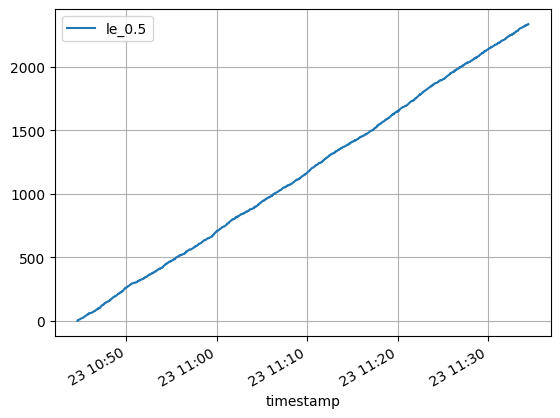

In [115]:
df_bin_by_group.query("path == '/home' and controller_pod == 'pod-1'").plot(kind="line", x="timestamp", y="le_0.5", grid=True)
plt.show()

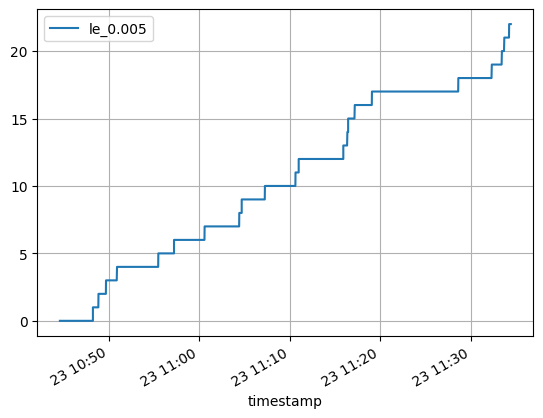

In [117]:
df_bin_by_group.query("path == '/home' and controller_pod == 'pod-1'").plot(kind="line", x="timestamp", y="le_0.005", grid=True)
plt.show()

### Description

Có thể thấy dữ liệu từ 2 bucket có latency nhỏ nhất (<= 0.005) và lớn nhất (<= 0.5)(không tính trường hợp bucket +Inf vì nó luôn tăng tuyến tính +1 theo từng giây) có sự khác biệt rõ ràng. Dễ nhận thấy rằng bucket có latency <= 0.5 sẽ biến động tăng đều và nhiều hơn so với bucket có latency <= 0.005. Nguyên nhân vì hầu hết các request ghi lại đều có duration_time <= 0.5 nhưng có khá it các request có duration_time <= 0.5 (Nghĩa là được xử lý trong khoảng thời gian 0.005 second -> duration_time <= 0.005 second)

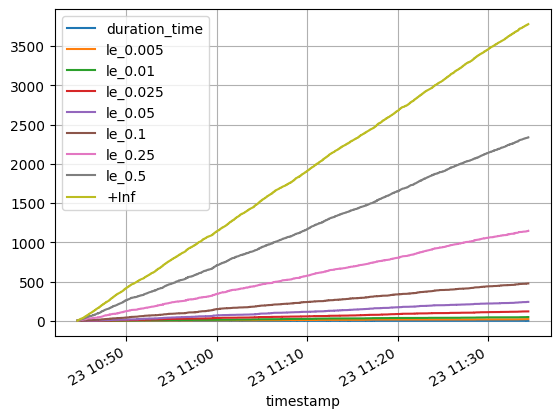

In [130]:
import matplotlib.dates as mdates
df_bin_by_group.query("path == '/home' and controller_pod == 'pod-1'").plot(kind="line", x="timestamp", grid=True)
ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.SecondLocator(interval=20))
plt.show()

In [183]:
df_bin_by_group_second = df_bin_by_group.groupby(["timestamp", "path", "controller_pod"]).nth(-1).reset_index(drop=True)
df_bin_by_group_second[0:20]

,timestamp,path,method,service_name,controller_pod,duration_time,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
0,2024-01-23 10:44:35,/home,GET,process_log,pod-1,0.252,0,0,0,0,0,0,1,2
1,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0.386,0,0,0,1,1,2,4,5
2,2024-01-23 10:44:37,/home,GET,process_log,pod-1,0.737,0,0,0,1,1,3,5,7
3,2024-01-23 10:44:39,/home,GET,process_log,pod-1,0.691,0,0,0,1,1,3,5,8
4,2024-01-23 10:44:40,/home,GET,process_log,pod-1,0.118,0,0,0,1,1,4,6,9
5,2024-01-23 10:44:41,/home,GET,process_log,pod-1,0.228,0,0,0,1,1,5,7,10
6,2024-01-23 10:44:42,/home,GET,process_log,pod-1,0.509,0,0,0,1,1,5,7,11
7,2024-01-23 10:44:45,/home,GET,process_log,pod-1,0.365,0,0,0,1,1,5,8,12
8,2024-01-23 10:44:46,/home,GET,process_log,pod-1,0.268,0,0,0,1,1,5,9,13
9,2024-01-23 10:44:47,/home,GET,process_log,pod-1,0.150,0,0,0,1,1,6,10,14


In [177]:
# Implement increase()
from datetime import timedelta


def increase(row, time_vector: int):
    """Calculate increase in time range
    Ex: increase(60) = increase (t-60,...,t)
    Args:
        time_vector (int): time range. Calculate by second
    """
    timestamp = row['timestamp']
    prev_timestamp = row['timestamp'] - timedelta(seconds=time_vector)
    # Query prev_timestamp to dataframe
    found_prev_timestamp = df_bin_by_group.query(
        "timestamp == @prev_timestamp"
    )
    if found_prev_timestamp.empty:
        return np.NaN
    else:
        return row['le_0.05']
    # print("Found: ", found_prev_timestamp)
    print("Row: ", timestamp, "Prev_time: ", prev_timestamp)

In [179]:
df_test_increase = df_bin_by_group
df_bin_by_group.query("path == '/home' and controller_pod == 'pod-1'").groupby(
    ["timestamp", "path", "controller_pod"]).nth(-1).reset_index(drop=True)[0:10].apply(lambda x: increase(x, time_vector=10), axis=1)

Not found
Row:  2024-01-23 10:44:35 Prev_time:  2024-01-23 10:44:25
Not found
Row:  2024-01-23 10:44:36 Prev_time:  2024-01-23 10:44:26
Not found
Row:  2024-01-23 10:44:37 Prev_time:  2024-01-23 10:44:27
Not found
Row:  2024-01-23 10:44:39 Prev_time:  2024-01-23 10:44:29
Not found
Row:  2024-01-23 10:44:40 Prev_time:  2024-01-23 10:44:30
Not found
Row:  2024-01-23 10:44:41 Prev_time:  2024-01-23 10:44:31
Not found
Row:  2024-01-23 10:44:42 Prev_time:  2024-01-23 10:44:32
Found
Row:  2024-01-23 10:44:45 Prev_time:  2024-01-23 10:44:35
Found
Row:  2024-01-23 10:44:46 Prev_time:  2024-01-23 10:44:36
Found
Row:  2024-01-23 10:44:47 Prev_time:  2024-01-23 10:44:37


0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
dtype: object

In [ ]:
# Implement rate()
def rate(time_vector: int):
    """Calculate increase in time range

    Args:
        time_vector (int): time range. Ex: 60 <- 1 minute
    """
    pass